# indicators

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numba import njit, f8, i8, b1, optional
import itertools

In [3]:
index = pd.Index([
    datetime(2018, 1, 1),
    datetime(2018, 1, 2),
    datetime(2018, 1, 3),
    datetime(2018, 1, 4),
    datetime(2018, 1, 5),
    datetime(2018, 1, 6),
    datetime(2018, 1, 7)
])
columns = ['a', 'b', 'c']
ts = pd.DataFrame({
    'a': [1, 2, 3, 4, 5, 6, np.nan], 
    'b': [np.nan, 6, 5, 4, 3, 2, 1],
    'c': [1, 2, 3, np.nan, 3, 2, 1]}, index=index).astype(np.float64)

print(ts)

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  6.0  2.0
2018-01-03  3.0  5.0  3.0
2018-01-04  4.0  4.0  NaN
2018-01-05  5.0  3.0  3.0
2018-01-06  6.0  2.0  2.0
2018-01-07  NaN  1.0  1.0


In [4]:
big_ts = pd.DataFrame(np.random.randint(10, size=(1000, 1000)).astype(float))
big_ts.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
big_ts.shape

(1000, 1000)

## IndicatorFactory

In [5]:
def apply_func(i, ts, p, a, b=100):
    return ts * p[i] + a + b

@njit
def apply_func_nb(i, ts, p, a):
    return ts * p[i] + a + 100 # numba doesn't support **kwargs

# Custom function can be anything that takes time series, params and other arguments, and returns outputs
def custom_func(ts, p, *args, **kwargs):
    return vbt.base.combine_fns.apply_and_concat_one(len(p), apply_func, ts, p, *args, **kwargs)

@njit
def custom_func_nb(ts, p, *args):
    return vbt.base.combine_fns.apply_and_concat_one_nb(len(p), apply_func_nb, ts, p, *args)

print(vbt.IndicatorFactory().from_custom_func(custom_func)\
      .from_params(ts, [0, 1, 2], 10).output)
print(vbt.IndicatorFactory().from_custom_func(custom_func_nb)\
      .from_params(ts, [0, 1, 2], 10).output)

custom_param      0                    1                    2              
                  a      b      c      a      b      c      a      b      c
2018-01-01    110.0    NaN  110.0  111.0    NaN  111.0  112.0    NaN  112.0
2018-01-02    110.0  110.0  110.0  112.0  116.0  112.0  114.0  122.0  114.0
2018-01-03    110.0  110.0  110.0  113.0  115.0  113.0  116.0  120.0  116.0
2018-01-04    110.0  110.0    NaN  114.0  114.0    NaN  118.0  118.0    NaN
2018-01-05    110.0  110.0  110.0  115.0  113.0  113.0  120.0  116.0  116.0
2018-01-06    110.0  110.0  110.0  116.0  112.0  112.0  122.0  114.0  114.0
2018-01-07      NaN  110.0  110.0    NaN  111.0  111.0    NaN  112.0  112.0
custom_param      0                    1                    2              
                  a      b      c      a      b      c      a      b      c
2018-01-01    110.0    NaN  110.0  111.0    NaN  111.0  112.0    NaN  112.0
2018-01-02    110.0  110.0  110.0  112.0  116.0  112.0  114.0  122.0  114.0
2018-01-03  

In [6]:
# Apply function is performed on each parameter individually, and each output is then stacked for you
# Apply functions are less customizable than custom functions, but are simpler to write
print(vbt.IndicatorFactory().from_apply_func(lambda ts, p: ts * p)\
      .from_params(ts, [0, 1, 2]).output)
print(vbt.IndicatorFactory().from_apply_func(njit(lambda ts, p: ts * p))\
      .from_params(ts, [0, 1, 2]).output)

custom_param    0              1               2           
                a    b    c    a    b    c     a     b    c
2018-01-01    0.0  NaN  0.0  1.0  NaN  1.0   2.0   NaN  2.0
2018-01-02    0.0  0.0  0.0  2.0  6.0  2.0   4.0  12.0  4.0
2018-01-03    0.0  0.0  0.0  3.0  5.0  3.0   6.0  10.0  6.0
2018-01-04    0.0  0.0  NaN  4.0  4.0  NaN   8.0   8.0  NaN
2018-01-05    0.0  0.0  0.0  5.0  3.0  3.0  10.0   6.0  6.0
2018-01-06    0.0  0.0  0.0  6.0  2.0  2.0  12.0   4.0  4.0
2018-01-07    NaN  0.0  0.0  NaN  1.0  1.0   NaN   2.0  2.0
custom_param    0              1               2           
                a    b    c    a    b    c     a     b    c
2018-01-01    0.0  NaN  0.0  1.0  NaN  1.0   2.0   NaN  2.0
2018-01-02    0.0  0.0  0.0  2.0  6.0  2.0   4.0  12.0  4.0
2018-01-03    0.0  0.0  0.0  3.0  5.0  3.0   6.0  10.0  6.0
2018-01-04    0.0  0.0  NaN  4.0  4.0  NaN   8.0   8.0  NaN
2018-01-05    0.0  0.0  0.0  5.0  3.0  3.0  10.0   6.0  6.0
2018-01-06    0.0  0.0  0.0  6.0  2.0  2

In [7]:
print(vbt.IndicatorFactory(ts_names=['ts1', 'ts2']).from_apply_func(lambda ts1, ts2, p: ts1 * ts2 * p)\
      .from_params(ts, ts+1, [0, 1, 2]).output) # test multiple ts
print(vbt.IndicatorFactory(ts_names=['ts1', 'ts2']).from_apply_func(njit(lambda ts1, ts2, p: ts1 * ts2 * p))\
      .from_params(ts, ts+1, [0, 1, 2]).output)

custom_param    0               1                 2            
                a    b    c     a     b     c     a     b     c
2018-01-01    0.0  NaN  0.0   2.0   NaN   2.0   4.0   NaN   4.0
2018-01-02    0.0  0.0  0.0   6.0  42.0   6.0  12.0  84.0  12.0
2018-01-03    0.0  0.0  0.0  12.0  30.0  12.0  24.0  60.0  24.0
2018-01-04    0.0  0.0  NaN  20.0  20.0   NaN  40.0  40.0   NaN
2018-01-05    0.0  0.0  0.0  30.0  12.0  12.0  60.0  24.0  24.0
2018-01-06    0.0  0.0  0.0  42.0   6.0   6.0  84.0  12.0  12.0
2018-01-07    NaN  0.0  0.0   NaN   2.0   2.0   NaN   4.0   4.0
custom_param    0               1                 2            
                a    b    c     a     b     c     a     b     c
2018-01-01    0.0  NaN  0.0   2.0   NaN   2.0   4.0   NaN   4.0
2018-01-02    0.0  0.0  0.0   6.0  42.0   6.0  12.0  84.0  12.0
2018-01-03    0.0  0.0  0.0  12.0  30.0  12.0  24.0  60.0  24.0
2018-01-04    0.0  0.0  NaN  20.0  20.0   NaN  40.0  40.0   NaN
2018-01-05    0.0  0.0  0.0  30.0  12.0 

In [8]:
print(vbt.IndicatorFactory(param_names=['p1', 'p2']).from_apply_func(lambda ts, p1, p2: ts * (p1 + p2))\
      .from_params(ts, [0, 1], [2, 3]).output) # test multiple params
print(vbt.IndicatorFactory(param_names=['p1', 'p2']).from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)))\
      .from_params(ts, [0, 1], [2, 3]).output)

custom_p1      0                1            
custom_p2      2                3            
               a     b    c     a     b     c
2018-01-01   2.0   NaN  2.0   4.0   NaN   4.0
2018-01-02   4.0  12.0  4.0   8.0  24.0   8.0
2018-01-03   6.0  10.0  6.0  12.0  20.0  12.0
2018-01-04   8.0   8.0  NaN  16.0  16.0   NaN
2018-01-05  10.0   6.0  6.0  20.0  12.0  12.0
2018-01-06  12.0   4.0  4.0  24.0   8.0   8.0
2018-01-07   NaN   2.0  2.0   NaN   4.0   4.0
custom_p1      0                1            
custom_p2      2                3            
               a     b    c     a     b     c
2018-01-01   2.0   NaN  2.0   4.0   NaN   4.0
2018-01-02   4.0  12.0  4.0   8.0  24.0   8.0
2018-01-03   6.0  10.0  6.0  12.0  20.0  12.0
2018-01-04   8.0   8.0  NaN  16.0  16.0   NaN
2018-01-05  10.0   6.0  6.0  20.0  12.0  12.0
2018-01-06  12.0   4.0  4.0  24.0   8.0   8.0
2018-01-07   NaN   2.0  2.0   NaN   4.0   4.0


In [9]:
print(vbt.IndicatorFactory(param_names=['p1', 'p2']).from_apply_func(lambda ts, p1, p2: ts * (p1 + p2))\
      .from_params(ts, [0, 1], [2, 3], param_product=True).output) # test param product
print(vbt.IndicatorFactory(param_names=['p1', 'p2']).from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)))\
      .from_params(ts, [0, 1], [2, 3], param_product=True).output)

custom_p1      0                                 1                         \
custom_p2      2                3                2                3         
               a     b    c     a     b    c     a     b    c     a     b   
2018-01-01   2.0   NaN  2.0   3.0   NaN  3.0   3.0   NaN  3.0   4.0   NaN   
2018-01-02   4.0  12.0  4.0   6.0  18.0  6.0   6.0  18.0  6.0   8.0  24.0   
2018-01-03   6.0  10.0  6.0   9.0  15.0  9.0   9.0  15.0  9.0  12.0  20.0   
2018-01-04   8.0   8.0  NaN  12.0  12.0  NaN  12.0  12.0  NaN  16.0  16.0   
2018-01-05  10.0   6.0  6.0  15.0   9.0  9.0  15.0   9.0  9.0  20.0  12.0   
2018-01-06  12.0   4.0  4.0  18.0   6.0  6.0  18.0   6.0  6.0  24.0   8.0   
2018-01-07   NaN   2.0  2.0   NaN   3.0  3.0   NaN   3.0  3.0   NaN   4.0   

custom_p1         
custom_p2         
               c  
2018-01-01   4.0  
2018-01-02   8.0  
2018-01-03  12.0  
2018-01-04   NaN  
2018-01-05  12.0  
2018-01-06   8.0  
2018-01-07   4.0  
custom_p1      0                       

In [10]:
print(vbt.IndicatorFactory(output_names=['o1', 'o2']).from_apply_func(lambda ts, p: (ts * p, ts * p ** 2))\
      .from_params(ts, [0, 1, 2]).o1) # test multiple outputs
print(vbt.IndicatorFactory(output_names=['o1', 'o2']).from_apply_func(njit(lambda ts, p: (ts * p, ts * p ** 2)))\
      .from_params(ts, [0, 1, 2]).o1)

custom_param    0              1               2           
                a    b    c    a    b    c     a     b    c
2018-01-01    0.0  NaN  0.0  1.0  NaN  1.0   2.0   NaN  2.0
2018-01-02    0.0  0.0  0.0  2.0  6.0  2.0   4.0  12.0  4.0
2018-01-03    0.0  0.0  0.0  3.0  5.0  3.0   6.0  10.0  6.0
2018-01-04    0.0  0.0  NaN  4.0  4.0  NaN   8.0   8.0  NaN
2018-01-05    0.0  0.0  0.0  5.0  3.0  3.0  10.0   6.0  6.0
2018-01-06    0.0  0.0  0.0  6.0  2.0  2.0  12.0   4.0  4.0
2018-01-07    NaN  0.0  0.0  NaN  1.0  1.0   NaN   2.0  2.0
custom_param    0              1               2           
                a    b    c    a    b    c     a     b    c
2018-01-01    0.0  NaN  0.0  1.0  NaN  1.0   2.0   NaN  2.0
2018-01-02    0.0  0.0  0.0  2.0  6.0  2.0   4.0  12.0  4.0
2018-01-03    0.0  0.0  0.0  3.0  5.0  3.0   6.0  10.0  6.0
2018-01-04    0.0  0.0  NaN  4.0  4.0  NaN   8.0   8.0  NaN
2018-01-05    0.0  0.0  0.0  5.0  3.0  3.0  10.0   6.0  6.0
2018-01-06    0.0  0.0  0.0  6.0  2.0  2

In [11]:
print(vbt.IndicatorFactory().from_apply_func(lambda ts, p, a: ts * p + a)\
      .from_params(ts, [0, 1, 2], 3).output) # test *args
print(vbt.IndicatorFactory().from_apply_func(njit(lambda ts, p, a: ts * p + a))\
      .from_params(ts, [0, 1, 2], 3).output)

custom_param    0              1               2           
                a    b    c    a    b    c     a     b    c
2018-01-01    3.0  NaN  3.0  4.0  NaN  4.0   5.0   NaN  5.0
2018-01-02    3.0  3.0  3.0  5.0  9.0  5.0   7.0  15.0  7.0
2018-01-03    3.0  3.0  3.0  6.0  8.0  6.0   9.0  13.0  9.0
2018-01-04    3.0  3.0  NaN  7.0  7.0  NaN  11.0  11.0  NaN
2018-01-05    3.0  3.0  3.0  8.0  6.0  6.0  13.0   9.0  9.0
2018-01-06    3.0  3.0  3.0  9.0  5.0  5.0  15.0   7.0  7.0
2018-01-07    NaN  3.0  3.0  NaN  4.0  4.0   NaN   5.0  5.0
custom_param    0              1               2           
                a    b    c    a    b    c     a     b    c
2018-01-01    3.0  NaN  3.0  4.0  NaN  4.0   5.0   NaN  5.0
2018-01-02    3.0  3.0  3.0  5.0  9.0  5.0   7.0  15.0  7.0
2018-01-03    3.0  3.0  3.0  6.0  8.0  6.0   9.0  13.0  9.0
2018-01-04    3.0  3.0  NaN  7.0  7.0  NaN  11.0  11.0  NaN
2018-01-05    3.0  3.0  3.0  8.0  6.0  6.0  13.0   9.0  9.0
2018-01-06    3.0  3.0  3.0  9.0  5.0  5

In [12]:
print(vbt.IndicatorFactory().from_apply_func(lambda ts, p, a=1: ts * p + a)\
      .from_params(ts, [0, 1, 2], a=3).output) # test **kwargs
# Numba doesn't support kwargs out of the box

custom_param    0              1               2           
                a    b    c    a    b    c     a     b    c
2018-01-01    3.0  NaN  3.0  4.0  NaN  4.0   5.0   NaN  5.0
2018-01-02    3.0  3.0  3.0  5.0  9.0  5.0   7.0  15.0  7.0
2018-01-03    3.0  3.0  3.0  6.0  8.0  6.0   9.0  13.0  9.0
2018-01-04    3.0  3.0  NaN  7.0  7.0  NaN  11.0  11.0  NaN
2018-01-05    3.0  3.0  3.0  8.0  6.0  6.0  13.0   9.0  9.0
2018-01-06    3.0  3.0  3.0  9.0  5.0  5.0  15.0   7.0  7.0
2018-01-07    NaN  3.0  3.0  NaN  4.0  4.0   NaN   5.0  5.0


In [13]:
print(vbt.IndicatorFactory().from_apply_func(
    lambda ts, param, c: ts * param * c, caching_func=lambda ts, params: 100)\
      .from_params(ts, [0, 1, 2]).output) # test caching func
print(vbt.IndicatorFactory().from_apply_func(
    njit(lambda ts, param, c: ts * param * c), caching_func=lambda ts, params: 100)\
      .from_params(ts, [0, 1, 2]).output)

custom_param    0                1                     2               
                a    b    c      a      b      c       a       b      c
2018-01-01    0.0  NaN  0.0  100.0    NaN  100.0   200.0     NaN  200.0
2018-01-02    0.0  0.0  0.0  200.0  600.0  200.0   400.0  1200.0  400.0
2018-01-03    0.0  0.0  0.0  300.0  500.0  300.0   600.0  1000.0  600.0
2018-01-04    0.0  0.0  NaN  400.0  400.0    NaN   800.0   800.0    NaN
2018-01-05    0.0  0.0  0.0  500.0  300.0  300.0  1000.0   600.0  600.0
2018-01-06    0.0  0.0  0.0  600.0  200.0  200.0  1200.0   400.0  400.0
2018-01-07    NaN  0.0  0.0    NaN  100.0  100.0     NaN   200.0  200.0
custom_param    0                1                     2               
                a    b    c      a      b      c       a       b      c
2018-01-01    0.0  NaN  0.0  100.0    NaN  100.0   200.0     NaN  200.0
2018-01-02    0.0  0.0  0.0  200.0  600.0  200.0   400.0  1200.0  400.0
2018-01-03    0.0  0.0  0.0  300.0  500.0  300.0   600.0  1000.0

In [14]:
CustomInd = vbt.IndicatorFactory(
    ts_names=['ts1', 'ts2'],
    param_names=['p1', 'p2'],
    output_names=['o1', 'o2']
).from_apply_func(lambda ts1, ts2, p1, p2: (ts1 * p1, ts2 * p2))

In [15]:
dir(CustomInd) # you can list here all of the available tools

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'from_params',
 'iloc',
 'loc',
 'name',
 'o1',
 'o1_above',
 'o1_below',
 'o1_equal',
 'o2',
 'o2_above',
 'o2_below',
 'o2_equal',
 'p1_loc',
 'p2_loc',
 'ts1',
 'ts1_above',
 'ts1_below',
 'ts1_equal',
 'ts2',
 'ts2_above',
 'ts2_below',
 'ts2_equal',
 'tuple_loc',
 'xs']

In [16]:
custom_ind = CustomInd.from_params(ts, ts * 2, [1, 2], [3, 4])
big_custom_ind = CustomInd.from_params(big_ts, big_ts * 2, [1, 2], [3, 4])

In [17]:
print(custom_ind.wrapper.index) # subclasses TSArrayWrapper
print(custom_ind.wrapper.columns)
print(custom_ind.wrapper.ndim)
print(custom_ind.wrapper.shape)
print(custom_ind.wrapper.freq)

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07'],
              dtype='datetime64[ns]', freq=None)
MultiIndex([(1, 3, 'a'),
            (1, 3, 'b'),
            (1, 3, 'c'),
            (2, 4, 'a'),
            (2, 4, 'b'),
            (2, 4, 'c')],
           names=['custom_p1', 'custom_p2', None])
2
(7, 6)
1 days 00:00:00


### Pandas indexing

In [18]:
print(custom_ind.o1.iloc[:, 0])
%timeit big_custom_ind.o1.iloc[:, 0] # benchmark, 1 column

print(custom_ind.iloc[:, 0].o1) # performed on the object itself
%timeit big_custom_ind.iloc[:, 0] # slower since it forwards the operation to each dataframe

2018-01-01    1.0
2018-01-02    2.0
2018-01-03    3.0
2018-01-04    4.0
2018-01-05    5.0
2018-01-06    6.0
2018-01-07    NaN
Name: (1, 3, a), dtype: float64
85.1 µs ± 5.27 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2018-01-01    1.0
2018-01-02    2.0
2018-01-03    3.0
2018-01-04    4.0
2018-01-05    5.0
2018-01-06    6.0
2018-01-07    NaN
Name: (1, 3, a), dtype: float64
11.9 ms ± 790 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
print(custom_ind.o1.iloc[:, np.arange(3)])
%timeit big_custom_ind.o1.iloc[:, np.arange(1000)] # 1000 columns

print(custom_ind.iloc[:, np.arange(3)].o1)
%timeit big_custom_ind.iloc[:, np.arange(1000)]

custom_p1     1          
custom_p2     3          
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  6.0  2.0
2018-01-03  3.0  5.0  3.0
2018-01-04  4.0  4.0  NaN
2018-01-05  5.0  3.0  3.0
2018-01-06  6.0  2.0  2.0
2018-01-07  NaN  1.0  1.0
3.57 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
custom_p1     1          
custom_p2     3          
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  6.0  2.0
2018-01-03  3.0  5.0  3.0
2018-01-04  4.0  4.0  NaN
2018-01-05  5.0  3.0  3.0
2018-01-06  6.0  2.0  2.0
2018-01-07  NaN  1.0  1.0
33.6 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
print(custom_ind.o1.loc[:, (1, 3, 'a')])
%timeit big_custom_ind.o1.loc[:, (1, 3, 0)] # 1 column

print(custom_ind.loc[:, (1, 3, 'a')].o1)
%timeit big_custom_ind.loc[:, (1, 3, 0)]

2018-01-01    1.0
2018-01-02    2.0
2018-01-03    3.0
2018-01-04    4.0
2018-01-05    5.0
2018-01-06    6.0
2018-01-07    NaN
Name: (1, 3, a), dtype: float64
87.3 µs ± 2.69 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2018-01-01    1.0
2018-01-02    2.0
2018-01-03    3.0
2018-01-04    4.0
2018-01-05    5.0
2018-01-06    6.0
2018-01-07    NaN
Name: (1, 3, a), dtype: float64
13.8 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
print(custom_ind.o1.loc[:, (1, 3)])
%timeit big_custom_ind.o1.loc[:, 1] # 1000 columns

print(custom_ind.loc[:, (1, 3)].o1)
%timeit big_custom_ind.loc[:, 1]

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  6.0  2.0
2018-01-03  3.0  5.0  3.0
2018-01-04  4.0  4.0  NaN
2018-01-05  5.0  3.0  3.0
2018-01-06  6.0  2.0  2.0
2018-01-07  NaN  1.0  1.0
459 µs ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  6.0  2.0
2018-01-03  3.0  5.0  3.0
2018-01-04  4.0  4.0  NaN
2018-01-05  5.0  3.0  3.0
2018-01-06  6.0  2.0  2.0
2018-01-07  NaN  1.0  1.0
14.4 ms ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
print(custom_ind.o1.xs(1, axis=1, level=0))
%timeit big_custom_ind.o1.xs(1, axis=1, level=0) # 1000 columns

print(custom_ind.xs(1, axis=1, level=0).o1)
%timeit big_custom_ind.xs(1, axis=1, level=0)

custom_p2     3          
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  6.0  2.0
2018-01-03  3.0  5.0  3.0
2018-01-04  4.0  4.0  NaN
2018-01-05  5.0  3.0  3.0
2018-01-06  6.0  2.0  2.0
2018-01-07  NaN  1.0  1.0
532 µs ± 72.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
custom_p2     3          
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  6.0  2.0
2018-01-03  3.0  5.0  3.0
2018-01-04  4.0  4.0  NaN
2018-01-05  5.0  3.0  3.0
2018-01-06  6.0  2.0  2.0
2018-01-07  NaN  1.0  1.0
12.5 ms ± 472 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Parameter indexing

In [23]:
# Indexing by parameter
print(custom_ind._p1_mapper)
print(custom_ind.p1_loc[2].o1)
print(custom_ind.p1_loc[1:2].o1)
print(custom_ind.p1_loc[[1, 1, 1]].o1)

custom_p1  custom_p2   
1          3          a    1
                      b    1
                      c    1
2          4          a    2
                      b    2
                      c    2
Name: custom_p1, dtype: int64
custom_p2      4           
               a     b    c
2018-01-01   2.0   NaN  2.0
2018-01-02   4.0  12.0  4.0
2018-01-03   6.0  10.0  6.0
2018-01-04   8.0   8.0  NaN
2018-01-05  10.0   6.0  6.0
2018-01-06  12.0   4.0  4.0
2018-01-07   NaN   2.0  2.0
custom_p1     1               2           
custom_p2     3               4           
              a    b    c     a     b    c
2018-01-01  1.0  NaN  1.0   2.0   NaN  2.0
2018-01-02  2.0  6.0  2.0   4.0  12.0  4.0
2018-01-03  3.0  5.0  3.0   6.0  10.0  6.0
2018-01-04  4.0  4.0  NaN   8.0   8.0  NaN
2018-01-05  5.0  3.0  3.0  10.0   6.0  6.0
2018-01-06  6.0  2.0  2.0  12.0   4.0  4.0
2018-01-07  NaN  1.0  1.0   NaN   2.0  2.0
custom_p1     1                                        
custom_p2     3                   

In [24]:
%timeit big_custom_ind.p1_loc[1] # 1000 columns
%timeit big_custom_ind.p1_loc[np.full(10, 1)] # 10000 columns

42.8 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
283 ms ± 28.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
print(custom_ind._tuple_mapper)
print(custom_ind.tuple_loc[(1, 3)].o1)
print(custom_ind.tuple_loc[(1, 3):(2, 4)].o1)

custom_p1  custom_p2   
1          3          a    (1, 3)
                      b    (1, 3)
                      c    (1, 3)
2          4          a    (2, 4)
                      b    (2, 4)
                      c    (2, 4)
Name: (custom_p1, custom_p2), dtype: object
              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  6.0  2.0
2018-01-03  3.0  5.0  3.0
2018-01-04  4.0  4.0  NaN
2018-01-05  5.0  3.0  3.0
2018-01-06  6.0  2.0  2.0
2018-01-07  NaN  1.0  1.0
custom_p1     1               2           
custom_p2     3               4           
              a    b    c     a     b    c
2018-01-01  1.0  NaN  1.0   2.0   NaN  2.0
2018-01-02  2.0  6.0  2.0   4.0  12.0  4.0
2018-01-03  3.0  5.0  3.0   6.0  10.0  6.0
2018-01-04  4.0  4.0  NaN   8.0   8.0  NaN
2018-01-05  5.0  3.0  3.0  10.0   6.0  6.0
2018-01-06  6.0  2.0  2.0  12.0   4.0  4.0
2018-01-07  NaN  1.0  1.0   NaN   2.0  2.0


In [26]:
%timeit big_custom_ind.tuple_loc[(1, 3)]
%timeit big_custom_ind.tuple_loc[[(1, 3)] * 10]

34.9 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
302 ms ± 54.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Comparison methods

In [27]:
print(custom_ind.o1 > 2)
%timeit big_custom_ind.o1.values > 2 # don't even try pandas

print(custom_ind.o1_above(2))
%timeit big_custom_ind.o1_above(2) # slower than numpy because of constructing dataframe

custom_p1       1                    2              
custom_p2       3                    4              
                a      b      c      a      b      c
2018-01-01  False  False  False  False  False  False
2018-01-02  False   True  False   True   True   True
2018-01-03   True   True   True   True   True   True
2018-01-04   True   True  False   True   True  False
2018-01-05   True   True   True   True   True   True
2018-01-06   True  False  False   True   True   True
2018-01-07  False  False  False  False  False  False
2.2 ms ± 256 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
custom_p1       1                    2              
custom_p2       3                    4              
                a      b      c      a      b      c
2018-01-01  False  False  False  False  False  False
2018-01-02  False   True  False   True   True   True
2018-01-03   True   True   True   True   True   True
2018-01-04   True   True  False   True   True  False
2018-01-05   True   True   T

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:336: RuntimeWarning: invalid value encountered in greater
  result = combine_func(new_obj_arr, new_other_arr, *args, **kwargs)


5.17 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
print(pd.concat((custom_ind.o1 > 2, custom_ind.o1 > 3), axis=1))
%timeit np.hstack((big_custom_ind.o1.values > 2, big_custom_ind.o1.values > 3))

print(custom_ind.o1_above([2, 3], multiple=True))
%timeit big_custom_ind.o1_above([2, 3], multiple=True)

custom_p1       1                    2                    1                \
custom_p2       3                    4                    3                 
                a      b      c      a      b      c      a      b      c   
2018-01-01  False  False  False  False  False  False  False  False  False   
2018-01-02  False   True  False   True   True   True  False   True  False   
2018-01-03   True   True   True   True   True   True  False   True  False   
2018-01-04   True   True  False   True   True  False   True   True  False   
2018-01-05   True   True   True   True   True   True   True  False  False   
2018-01-06   True  False  False   True   True   True   True  False  False   
2018-01-07  False  False  False  False  False  False  False  False  False   

custom_p1       2                
custom_p2       4                
                a      b      c  
2018-01-01  False  False  False  
2018-01-02   True   True   True  
2018-01-03   True   True   True  
2018-01-04   True   True 

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/combine_fns.py:115: RuntimeWarning: invalid value encountered in greater
  return combine_func(obj, others[i], *args, **kwargs)


18.5 ms ± 394 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## MA

In [29]:
print(vbt.MA.from_params(ts['a'], 2).ma)
print(vbt.MA.from_params(ts, 2).ma)
print(vbt.MA.from_params(ts, [2, 3], ewm=False).ma)
print(vbt.MA.from_params(ts, [2, 3], ewm=[False, True]).ma)
print(vbt.MA.from_params(ts, [2, 3], ewm=[False, True], param_product=True).ma)

2018-01-01    NaN
2018-01-02    1.5
2018-01-03    2.5
2018-01-04    3.5
2018-01-05    4.5
2018-01-06    5.5
2018-01-07    NaN
Name: (2, False, a), dtype: float64
              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.5  NaN  1.5
2018-01-03  2.5  5.5  2.5
2018-01-04  3.5  4.5  NaN
2018-01-05  4.5  3.5  NaN
2018-01-06  5.5  2.5  2.5
2018-01-07  NaN  1.5  1.5
ma_window      2               3          
ma_ewm     False           False          
               a    b    c     a    b    c
2018-01-01   NaN  NaN  NaN   NaN  NaN  NaN
2018-01-02   1.5  NaN  1.5   NaN  NaN  NaN
2018-01-03   2.5  5.5  2.5   2.0  NaN  2.0
2018-01-04   3.5  4.5  NaN   3.0  5.0  NaN
2018-01-05   4.5  3.5  NaN   4.0  4.0  NaN
2018-01-06   5.5  2.5  2.5   5.0  3.0  NaN
2018-01-07   NaN  1.5  1.5   NaN  2.0  2.0
ma_window      2                   3                    
ma_ewm     False               True                     
               a    b    c         a         b         c
2018-01-01   NaN  NaN  NaN   

In [30]:
# One window
%timeit big_ts.rolling(2).mean() # pandas
%timeit vbt.MA.from_params(big_ts, 2, return_cache=True) # cache only
%timeit vbt.MA.from_params(big_ts, 2) # with pre+postprocessing and still beats pandas

print(vbt.MA.from_params(big_ts, 2).ma.shape)

32.5 ms ± 982 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
17 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
26.7 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


In [31]:
# Multiple windows
%timeit pd.concat([big_ts.rolling(i).mean() for i in np.arange(2, 100)])
%timeit vbt.MA.from_params(big_ts, np.arange(2, 100), return_cache=True) # cache only
%timeit vbt.MA.from_params(big_ts, np.arange(2, 100))
cache = vbt.MA.from_params(big_ts, np.arange(2, 100), return_cache=True)
%timeit vbt.MA.from_params(big_ts, np.arange(2, 100), cache=cache) # using cache

print(vbt.MA.from_params(big_ts, np.arange(2, 100)).ma.shape)

4.4 s ± 445 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.96 s ± 56.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.36 s ± 512 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.82 s ± 618 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 98000)


In [32]:
# One window repeated
%timeit pd.concat([big_ts.rolling(i).mean() for i in np.full(100, 2)])
%timeit vbt.MA.from_params(big_ts, np.full(100, 2), return_cache=True)
%timeit vbt.MA.from_params(big_ts, np.full(100, 2))

print(vbt.MA.from_params(big_ts, np.full(100, 2)).ma.shape)

4.05 s ± 56.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15.5 ms ± 272 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.44 s ± 354 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 100000)


In [33]:
ma = vbt.MA.from_params(ts, [2, 3], ewm=[False, True])
big_ma = vbt.MA.from_params(big_ts, np.arange(2, 100), ewm=False)

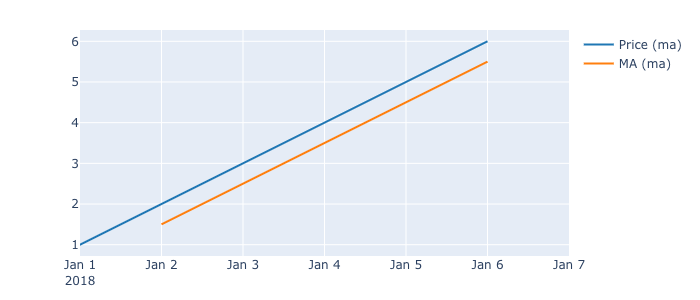

In [34]:
ma[(2, False, 'a')].plot().show_png()

### Combinations

In [35]:
comb = itertools.combinations(np.arange(2, 20), 2)
fast_windows, slow_windows = np.asarray(list(comb)).transpose()
print(fast_windows, slow_windows)

%timeit vbt.MA.from_params(big_ts, fast_windows), vbt.MA.from_params(big_ts, slow_windows) # naive way
%timeit vbt.MA.from_combinations(big_ts, np.arange(2, 20), 2) # performs caching -> a bit faster

[ 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6
  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8
  8  8  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 11 11 11
 11 11 11 11 11 12 12 12 12 12 12 12 13 13 13 13 13 13 14 14 14 14 14 15
 15 15 15 16 16 16 17 17 18] [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  4  5  6  7  8  9 10
 11 12 13 14 15 16 17 18 19  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
  6  7  8  9 10 11 12 13 14 15 16 17 18 19  7  8  9 10 11 12 13 14 15 16
 17 18 19  8  9 10 11 12 13 14 15 16 17 18 19  9 10 11 12 13 14 15 16 17
 18 19 10 11 12 13 14 15 16 17 18 19 11 12 13 14 15 16 17 18 19 12 13 14
 15 16 17 18 19 13 14 15 16 17 18 19 14 15 16 17 18 19 15 16 17 18 19 16
 17 18 19 17 18 19 18 19 19]
4.76 s ± 681 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [36]:
ma1, ma2 = vbt.MA.from_combinations(ts, [2, 3, 4], 2, ewm=[False, False, True])

print(ma1.ma)
print(ma2.ma)

ma1_window     2                              3          
ma1_ewm    False                          False          
               a    b    c    a    b    c     a    b    c
2018-01-01   NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN
2018-01-02   1.5  NaN  1.5  1.5  NaN  1.5   NaN  NaN  NaN
2018-01-03   2.5  5.5  2.5  2.5  5.5  2.5   2.0  NaN  2.0
2018-01-04   3.5  4.5  NaN  3.5  4.5  NaN   3.0  5.0  NaN
2018-01-05   4.5  3.5  NaN  4.5  3.5  NaN   4.0  4.0  NaN
2018-01-06   5.5  2.5  2.5  5.5  2.5  2.5   5.0  3.0  NaN
2018-01-07   NaN  1.5  1.5  NaN  1.5  1.5   NaN  2.0  2.0
ma2_window     3                   4                                          \
ma2_ewm    False               True                                            
               a    b    c         a         b         c         a         b   
2018-01-01   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
2018-01-02   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
2018-01-03   2.0  Na

In [37]:
print(ma1.ma_above(ma2, crossed=True))
print(ma1.ma_below(ma2, crossed=True))

ma1_window      2                                         3              
ma1_ewm     False                                     False              
ma2_window      3                    4                    4              
ma2_ewm     False                True                 True               
                a      b      c      a      b      c      a      b      c
2018-01-01  False  False  False  False  False  False  False  False  False
2018-01-02  False  False  False  False  False  False  False  False  False
2018-01-03   True  False   True  False  False  False  False  False  False
2018-01-04  False  False  False   True  False  False  False  False  False
2018-01-05  False  False  False  False  False  False   True   True  False
2018-01-06  False  False  False  False  False   True  False  False  False
2018-01-07  False  False  False  False  False  False  False  False   True
ma1_window      2                                         3              
ma1_ewm     False                     

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:336: RuntimeWarning:

invalid value encountered in greater

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:336: RuntimeWarning:

invalid value encountered in less



## MSTD

In [38]:
print(vbt.MSTD.from_params(ts['a'], 2).mstd)
print(vbt.MSTD.from_params(ts, 2).mstd)
print(vbt.MSTD.from_params(ts, [2, 3], ewm=False).mstd)
print(vbt.MSTD.from_params(ts, [2, 3], ewm=[False, True]).mstd)
print(vbt.MSTD.from_params(ts, [2, 3], ewm=[False, True], param_product=True).mstd)

2018-01-01         NaN
2018-01-02    0.707107
2018-01-03    0.707107
2018-01-04    0.707107
2018-01-05    0.707107
2018-01-06    0.707107
2018-01-07         NaN
Name: (2, False, a), dtype: float64
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.707107       NaN  0.707107
2018-01-03  0.707107  0.707107  0.707107
2018-01-04  0.707107  0.707107       NaN
2018-01-05  0.707107  0.707107       NaN
2018-01-06  0.707107  0.707107  0.707107
2018-01-07       NaN  0.707107  0.707107
mstd_window         2                         3          
mstd_ewm        False                     False          
                    a         b         c     a    b    c
2018-01-01        NaN       NaN       NaN   NaN  NaN  NaN
2018-01-02   0.707107       NaN  0.707107   NaN  NaN  NaN
2018-01-03   0.707107  0.707107  0.707107   1.0  NaN  1.0
2018-01-04   0.707107  0.707107       NaN   1.0  1.0  NaN
2018-01-05   0.707107  0.707107       NaN   1.0  1.0  NaN
2018-01-06 

In [39]:
# One window
%timeit big_ts.rolling(2).std()
%timeit vbt.MSTD.from_params(big_ts, 2)

print(vbt.MSTD.from_params(big_ts, 2).mstd.shape)

54.5 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
24 ms ± 259 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


In [40]:
# Multiple windows
%timeit pd.concat([big_ts.rolling(i).std() for i in np.arange(2, 100)])
%timeit vbt.MSTD.from_params(big_ts, np.arange(2, 100))

print(vbt.MSTD.from_params(big_ts, np.arange(2, 100)).mstd.shape)

6.09 s ± 56.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.86 s ± 17.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 98000)


In [41]:
# One window repeated
%timeit vbt.MA.from_params(big_ts, np.full(100, 2))

print(vbt.MSTD.from_params(big_ts, np.full(100, 2)).mstd.shape)

981 ms ± 24.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 100000)


In [42]:
mstd = vbt.MSTD.from_params(ts, [2, 3], [False, True])

print(mstd.mstd)

mstd_window         2                             3                    
mstd_ewm        False                         True                     
                    a         b         c         a         b         c
2018-01-01        NaN       NaN       NaN       NaN       NaN       NaN
2018-01-02   0.707107       NaN  0.707107       NaN       NaN       NaN
2018-01-03   0.707107  0.707107  0.707107  0.963624       NaN  0.963624
2018-01-04   0.707107  0.707107       NaN  1.177164  0.963624  0.963624
2018-01-05   0.707107  0.707107       NaN  1.345243  1.177164  0.695792
2018-01-06   0.707107  0.707107  0.707107  1.470916  1.345243  0.678643
2018-01-07        NaN  0.707107  0.707107  1.470916  1.470916  0.960778


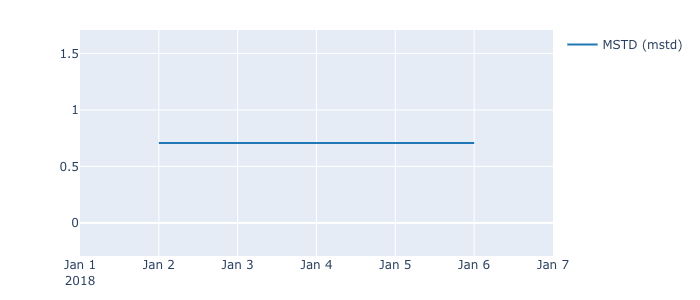

In [43]:
mstd[(2, False, 'a')].plot().show_png()

## BollingerBands

In [44]:
print(vbt.BollingerBands.from_params(ts, window=2, alpha=1).ma)
print(vbt.BollingerBands.from_params(ts, window=[2, 3], ewm=False, alpha=1.5).ma)
print(vbt.BollingerBands.from_params(ts, window=[2, 3], ewm=[False, True], alpha=[1, 2]).ma)
print(vbt.BollingerBands.from_params(ts, window=[2, 3], ewm=[False, True], alpha=[1, 2], param_product=True).ma)

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.5  NaN  1.5
2018-01-03  2.5  5.5  2.5
2018-01-04  3.5  4.5  NaN
2018-01-05  4.5  3.5  NaN
2018-01-06  5.5  2.5  2.5
2018-01-07  NaN  1.5  1.5
bb_window      2               3          
bb_ewm     False           False          
bb_alpha     1.5             1.5          
               a    b    c     a    b    c
2018-01-01   NaN  NaN  NaN   NaN  NaN  NaN
2018-01-02   1.5  NaN  1.5   NaN  NaN  NaN
2018-01-03   2.5  5.5  2.5   2.0  NaN  2.0
2018-01-04   3.5  4.5  NaN   3.0  5.0  NaN
2018-01-05   4.5  3.5  NaN   4.0  4.0  NaN
2018-01-06   5.5  2.5  2.5   5.0  3.0  NaN
2018-01-07   NaN  1.5  1.5   NaN  2.0  2.0
bb_window      2                   3                    
bb_ewm     False               True                     
bb_alpha     1.0                 2.0                    
               a    b    c         a         b         c
2018-01-01   NaN  NaN  NaN       NaN       NaN       NaN
2018-01-02   1.5  NaN  1.5       N

In [45]:
# One window
%timeit vbt.BollingerBands.from_params(big_ts)

print(vbt.BollingerBands.from_params(big_ts).ts.shape)

54.4 ms ± 3.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [46]:
# Multiple windows
%timeit vbt.BollingerBands.from_params(big_ts, window=np.arange(2, 100))

print(vbt.BollingerBands.from_params(big_ts, window=np.arange(2, 100)).ts.shape)

6.4 s ± 28.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 98000)


In [47]:
# One window repeated
%timeit vbt.BollingerBands.from_params(big_ts, window=np.full(100, 2))

print(vbt.BollingerBands.from_params(big_ts, window=np.full(100, 2)).ts.shape)

2.85 s ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 100000)


In [48]:
bb = vbt.BollingerBands.from_params(ts, window=2, alpha=[1., 2.], ewm=False)

print(bb.upper_band)
print()
print(bb.ma)
print()
print(bb.lower_band)
print()
print(bb.percent_b)
print()
print(bb.bandwidth)

bb_window          2                                                  
bb_ewm         False                                                  
bb_alpha         1.0                           2.0                    
                   a         b         c         a         b         c
2018-01-01       NaN       NaN       NaN       NaN       NaN       NaN
2018-01-02  2.207107       NaN  2.207107  2.914214       NaN  2.914214
2018-01-03  3.207107  6.207107  3.207107  3.914214  6.914214  3.914214
2018-01-04  4.207107  5.207107       NaN  4.914214  5.914214       NaN
2018-01-05  5.207107  4.207107       NaN  5.914214  4.914214       NaN
2018-01-06  6.207107  3.207107  3.207107  6.914214  3.914214  3.914214
2018-01-07       NaN  2.207107  2.207107       NaN  2.914214  2.914214

bb_window      2                         
bb_ewm     False                         
bb_alpha     1.0            2.0          
               a    b    c    a    b    c
2018-01-01   NaN  NaN  NaN  NaN  NaN  NaN
2018-01-

In [49]:
print(bb.ts_below(bb.upper_band) & bb.ts_above(bb.lower_band)) # price between bands

bb_window       2                                   
bb_ewm      False                                   
bb_alpha      1.0                  2.0              
                a      b      c      a      b      c
2018-01-01  False  False  False  False  False  False
2018-01-02   True  False   True   True  False   True
2018-01-03   True   True   True   True   True   True
2018-01-04   True   True  False   True   True  False
2018-01-05   True   True  False   True   True  False
2018-01-06   True   True   True   True   True   True
2018-01-07  False   True   True  False   True   True


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:336: RuntimeWarning:

invalid value encountered in less

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:336: RuntimeWarning:

invalid value encountered in greater



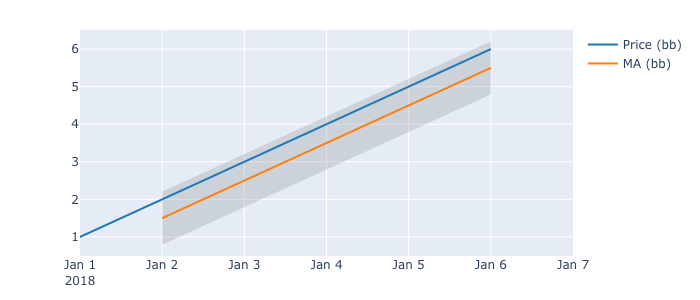

In [50]:
bb[(2, False, 1., 'a')].plot().show_png()

## RSI

In [51]:
print(vbt.RSI.from_params(ts['a'], window=2).rsi)
print(vbt.RSI.from_params(ts, window=2).rsi)
print(vbt.RSI.from_params(ts, window=[2, 3], ewm=False).rsi)
print(vbt.RSI.from_params(ts, window=[2, 3], ewm=[False, True]).rsi)
print(vbt.RSI.from_params(ts, window=[2, 3], ewm=[False, True], param_product=True).rsi)

2018-01-01      NaN
2018-01-02      NaN
2018-01-03    100.0
2018-01-04    100.0
2018-01-05    100.0
2018-01-06    100.0
2018-01-07      NaN
Name: (2, False, a), dtype: float64
                a    b      c
2018-01-01    NaN  NaN    NaN
2018-01-02    NaN  NaN    NaN
2018-01-03  100.0  NaN  100.0
2018-01-04  100.0  0.0    NaN
2018-01-05  100.0  0.0    NaN
2018-01-06  100.0  0.0    NaN
2018-01-07    NaN  0.0    0.0
rsi_window      2                  3         
rsi_ewm     False              False         
                a    b      c      a    b   c
2018-01-01    NaN  NaN    NaN    NaN  NaN NaN
2018-01-02    NaN  NaN    NaN    NaN  NaN NaN
2018-01-03  100.0  NaN  100.0    NaN  NaN NaN
2018-01-04  100.0  0.0    NaN  100.0  NaN NaN
2018-01-05  100.0  0.0    NaN  100.0  0.0 NaN
2018-01-06  100.0  0.0    NaN  100.0  0.0 NaN
2018-01-07    NaN  0.0    0.0    NaN  0.0 NaN
rsi_window      2                  3                
rsi_ewm     False              True                 
                a 

In [52]:
# One window
%timeit vbt.RSI.from_params(big_ts, window=2)

print(vbt.RSI.from_params(big_ts, window=2).rsi.shape)

63.3 ms ± 601 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


In [53]:
# Multiple windows
%timeit vbt.RSI.from_params(big_ts, window=np.arange(2, 100))

print(vbt.RSI.from_params(big_ts, window=np.arange(2, 100)).rsi.shape)

4.89 s ± 25.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 98000)


In [54]:
# One window repeated
%timeit vbt.RSI.from_params(big_ts, window=np.full(100, 2))

print(vbt.RSI.from_params(big_ts, window=np.full(100, 2)).rsi.shape)

1.39 s ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 100000)


In [55]:
rsi = vbt.RSI.from_params(ts, window=[2, 3], ewm=[False, True])

print(rsi.rsi)

rsi_window      2                  3                
rsi_ewm     False              True                 
                a    b      c      a    b          c
2018-01-01    NaN  NaN    NaN    NaN  NaN        NaN
2018-01-02    NaN  NaN    NaN    NaN  NaN        NaN
2018-01-03  100.0  NaN  100.0    NaN  NaN        NaN
2018-01-04  100.0  0.0    NaN  100.0  NaN        NaN
2018-01-05  100.0  0.0    NaN  100.0  0.0        NaN
2018-01-06  100.0  0.0    NaN  100.0  0.0  15.789474
2018-01-07    NaN  0.0    0.0  100.0  0.0   5.882353


In [56]:
print(rsi.rsi_above(70))

rsi_window      2                    3              
rsi_ewm     False                True               
                a      b      c      a      b      c
2018-01-01  False  False  False  False  False  False
2018-01-02  False  False  False  False  False  False
2018-01-03   True  False   True  False  False  False
2018-01-04   True  False  False   True  False  False
2018-01-05   True  False  False   True  False  False
2018-01-06   True  False  False   True  False  False
2018-01-07  False  False  False   True  False  False


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:336: RuntimeWarning:

invalid value encountered in greater



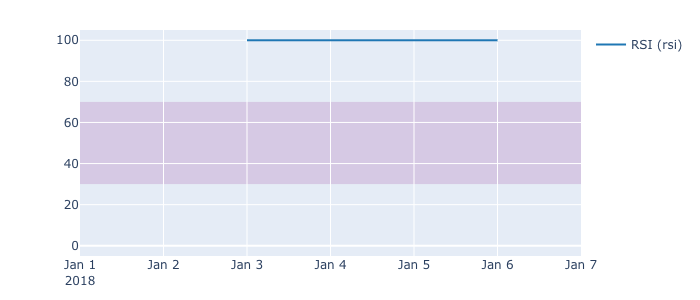

In [57]:
rsi[(2, False, 'a')].plot().show_png()

## Stochastic

In [58]:
print(vbt.Stochastic.from_params(ts['a'], k_window=2, d_window=3, d_ewm=False).percent_d)
print(vbt.Stochastic.from_params(ts['a'], high_ts=ts['a']*1.1, low_ts=ts['a']*0.9, k_window=2, d_window=3).percent_d)
print(vbt.Stochastic.from_params(ts, k_window=2, d_window=3).percent_d)
print(vbt.Stochastic.from_params(ts, k_window=2, d_window=[2, 3]).percent_d)
print(vbt.Stochastic.from_params(ts, k_window=[2, 3], d_window=[2, 3]).percent_d)
print(vbt.Stochastic.from_params(ts, k_window=[2, 3], d_window=[2, 3], param_product=True).percent_d)

2018-01-01      NaN
2018-01-02      NaN
2018-01-03      NaN
2018-01-04    100.0
2018-01-05    100.0
2018-01-06    100.0
2018-01-07      NaN
Name: (2, 3, False, a), dtype: float64
2018-01-01          NaN
2018-01-02          NaN
2018-01-03          NaN
2018-01-04    80.361991
2018-01-05    76.718266
2018-01-06    73.861123
2018-01-07          NaN
Name: (2, 3, False, a), dtype: float64
                a    b   c
2018-01-01    NaN  NaN NaN
2018-01-02    NaN  NaN NaN
2018-01-03    NaN  NaN NaN
2018-01-04  100.0  NaN NaN
2018-01-05  100.0  0.0 NaN
2018-01-06  100.0  0.0 NaN
2018-01-07    NaN  0.0 NaN
stoch_k_window      2                            
stoch_d_window      2                  3         
stoch_d_ewm     False              False         
                    a    b      c      a    b   c
2018-01-01        NaN  NaN    NaN    NaN  NaN NaN
2018-01-02        NaN  NaN    NaN    NaN  NaN NaN
2018-01-03      100.0  NaN  100.0    NaN  NaN NaN
2018-01-04      100.0  0.0    NaN  100.0  NaN Na

In [59]:
# One window
%timeit vbt.Stochastic.from_params(big_ts, k_window=2)

print(vbt.Stochastic.from_params(big_ts, k_window=2).percent_d.shape)

57.6 ms ± 549 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


In [60]:
# Multiple windows
%timeit vbt.Stochastic.from_params(big_ts, k_window=np.arange(2, 100)) # rolling min/max very expensive

print(vbt.Stochastic.from_params(big_ts, k_window=np.arange(2, 100)).percent_d.shape)

25.9 s ± 527 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 98000)


In [61]:
# One window repeated
%timeit vbt.Stochastic.from_params(big_ts, k_window=np.full(100, 2))

print(vbt.Stochastic.from_params(big_ts, k_window=np.full(100, 2)).percent_d.shape)

4.27 s ± 45.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 100000)


In [62]:
stochastic = vbt.Stochastic.from_params(
    ts, high_ts=ts*1.1, low_ts=ts*0.9, k_window=[2, 4], d_window=2, d_ewm=[False, True])

print(stochastic.percent_k)
print(stochastic.percent_d)

stoch_k_window          2                                4              
stoch_d_window          2                                2              
stoch_d_ewm         False                            True               
                        a          b          c          a         b   c
2018-01-01            NaN        NaN        NaN        NaN       NaN NaN
2018-01-02      84.615385        NaN  84.615385        NaN       NaN NaN
2018-01-03      80.000000  23.809524  80.000000        NaN       NaN NaN
2018-01-04      76.470588  21.052632        NaN  88.571429       NaN NaN
2018-01-05      73.684211  17.647059        NaN  86.486486  7.692308 NaN
2018-01-06      71.428571  13.333333  13.333333  84.615385  5.405405 NaN
2018-01-07            NaN   7.692308   7.692308        NaN  2.857143 NaN
stoch_k_window          2                                4              
stoch_d_window          2                                2              
stoch_d_ewm         False                          

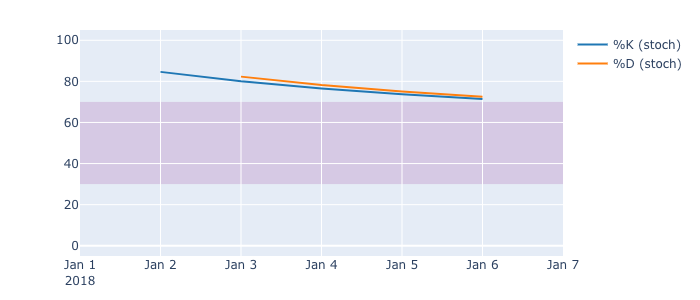

In [63]:
stochastic[(2, 2, False, 'a')].plot().show_png()

## MACD

In [64]:
print(vbt.MACD.from_params(ts['a'], fast_window=2, slow_window=4, 
    signal_window=2, macd_ewm=True, signal_ewm=True).signal)
print(vbt.MACD.from_params(ts, fast_window=2, slow_window=4, 
    signal_window=2, macd_ewm=True, signal_ewm=True).signal)
print(vbt.MACD.from_params(ts, fast_window=[2, 3], slow_window=4, 
    signal_window=2, macd_ewm=True, signal_ewm=[False, True]).signal)
print(vbt.MACD.from_params(ts, fast_window=[2, 3], slow_window=4, 
    signal_window=2, macd_ewm=True, signal_ewm=[False, True], param_product=True).signal)

2018-01-01         NaN
2018-01-02         NaN
2018-01-03         NaN
2018-01-04         NaN
2018-01-05    0.562912
2018-01-06    0.667931
2018-01-07    0.699437
Name: (2, 4, 2, True, True, a), dtype: float64
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02       NaN       NaN       NaN
2018-01-03       NaN       NaN       NaN
2018-01-04       NaN       NaN       NaN
2018-01-05  0.562912       NaN       NaN
2018-01-06  0.667931 -0.562912 -0.019218
2018-01-07  0.699437 -0.667931 -0.247370
macd_fast_window           2                             3                    
macd_slow_window           4                             4                    
macd_signal_window         2                             2                    
macd_macd_ewm           True                          True                    
macd_signal_ewm        False                         True                     
                           a         b         c         a         b 

In [65]:
# One window
%timeit vbt.MACD.from_params(big_ts, fast_window=2)

print(vbt.MACD.from_params(big_ts, fast_window=2).macd.shape)

69 ms ± 641 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


In [66]:
# Multiple windows
%timeit vbt.MACD.from_params(big_ts, fast_window=np.arange(2, 100))

print(vbt.MACD.from_params(big_ts, fast_window=np.arange(2, 100)).macd.shape)

5.54 s ± 29.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 98000)


In [67]:
# One window repeated
%timeit vbt.MACD.from_params(big_ts, fast_window=np.full(100, 2))

print(vbt.MACD.from_params(big_ts, fast_window=np.full(100, 2)).macd.shape)

4.08 s ± 34.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 100000)


In [68]:
macd = vbt.MACD.from_params(ts, fast_window=[2, 3], slow_window=4, signal_window=2, macd_ewm=True, signal_ewm=True)

print(macd.fast_ma)
print(macd.slow_ma)
print(macd.macd)
print(macd.signal)
print(macd.histogram)

macd_fast_window           2                             3                    
macd_slow_window           4                             4                    
macd_signal_window         2                             2                    
macd_macd_ewm           True                          True                    
macd_signal_ewm         True                          True                    
                           a         b         c         a         b         c
2018-01-01               NaN       NaN       NaN       NaN       NaN       NaN
2018-01-02          1.750000       NaN  1.750000       NaN       NaN       NaN
2018-01-03          2.615385  5.250000  2.615385  2.428571       NaN  2.428571
2018-01-04          3.550000  4.384615  2.615385  3.266667  4.571429  2.428571
2018-01-05          4.520661  3.450000  2.946809  4.161290  3.733333  2.826087
2018-01-06          5.508242  2.479339  2.264095  5.095238  2.838710  2.345455
2018-01-07          5.508242  1.491758  1.399625  5.

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:1053: RuntimeWarning:

invalid value encountered in greater

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:1054: RuntimeWarning:

invalid value encountered in greater

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:1054: RuntimeWarning:

invalid value encountered in less_equal

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:1056: RuntimeWarning:

invalid value encountered in less

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:1057: RuntimeWarning:

invalid value encountered in less

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:1057: RuntimeWarning:

invalid value encountered in greater_equal



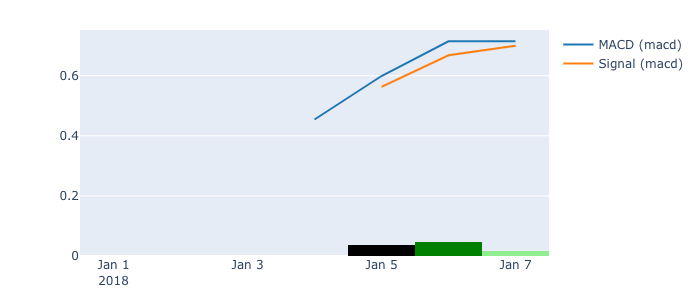

In [69]:
macd[(2, 4, 2, True, True, 'a')].plot().show_png()

## OBV

In [70]:
print(vbt.OBV.from_params(ts['a'], ts['b']).obv)
print(vbt.OBV.from_params(ts['a'], ts).obv)
print(vbt.OBV.from_params(ts, ts['b']).obv)
print(vbt.OBV.from_params(ts, ts.iloc[:, ::-1]).obv)

2018-01-01     NaN
2018-01-02     6.0
2018-01-03    11.0
2018-01-04    15.0
2018-01-05    18.0
2018-01-06    20.0
2018-01-07     NaN
Name: (a, b), dtype: float64
               a     b     c
2018-01-01   NaN   NaN   NaN
2018-01-02   2.0   6.0   2.0
2018-01-03   5.0  11.0   5.0
2018-01-04   9.0  15.0   NaN
2018-01-05  14.0  18.0   8.0
2018-01-06  20.0  20.0  10.0
2018-01-07   NaN   NaN   NaN
               a     b     c
2018-01-01   NaN   NaN   NaN
2018-01-02   6.0   NaN   6.0
2018-01-03  11.0  -5.0  11.0
2018-01-04  15.0  -9.0   NaN
2018-01-05  18.0 -12.0   NaN
2018-01-06  20.0 -14.0   9.0
2018-01-07   NaN -15.0   8.0
               a     b    c
               c     b    a
2018-01-01   NaN   NaN  NaN
2018-01-02   2.0   NaN  2.0
2018-01-03   5.0  -5.0  5.0
2018-01-04   NaN  -9.0  NaN
2018-01-05   8.0 -12.0  NaN
2018-01-06  10.0 -14.0 -1.0
2018-01-07   NaN -15.0  NaN


In [71]:
%timeit vbt.OBV.from_params(big_ts, big_ts.iloc[:, ::-1])

print(vbt.OBV.from_params(big_ts, big_ts.iloc[:, ::-1]).obv.shape)

19.2 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [72]:
obv = vbt.OBV.from_params(ts, ts.iloc[:, ::-1])

print(obv.obv)

               a     b    c
               c     b    a
2018-01-01   NaN   NaN  NaN
2018-01-02   2.0   NaN  2.0
2018-01-03   5.0  -5.0  5.0
2018-01-04   NaN  -9.0  NaN
2018-01-05   8.0 -12.0  NaN
2018-01-06  10.0 -14.0 -1.0
2018-01-07   NaN -15.0  NaN


In [73]:
print(obv.obv_above([0, 5], multiple=True))

obv_above       0                    5              
                a      b      c      a      b      c
                c      b      a      c      b      a
2018-01-01  False  False  False  False  False  False
2018-01-02   True  False   True  False  False  False
2018-01-03   True  False   True  False  False  False
2018-01-04  False  False  False  False  False  False
2018-01-05   True  False  False   True  False  False
2018-01-06   True  False  False   True  False  False
2018-01-07  False  False  False  False  False  False


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/combine_fns.py:115: RuntimeWarning:

invalid value encountered in greater



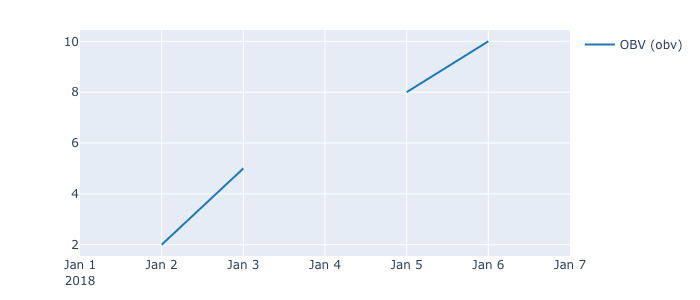

In [74]:
obv[('a', 'c')].plot().show_png()

## ATR

In [75]:
print(vbt.ATR.from_params(ts['a'], ts['a']*1.1, ts['a']*0.9, window=2).atr)
print(vbt.ATR.from_params(ts, ts['a']*1.1, ts['a']*0.9, window=2).atr)
print(vbt.ATR.from_params(ts, ts*1.1, ts*0.9, window=[2, 3]).atr)
print(vbt.ATR.from_params(ts, ts*1.1, ts*0.9, window=[2, 3], ewm=[False, True], param_product=True).atr)

2018-01-01         NaN
2018-01-02    0.950000
2018-01-03    1.192308
2018-01-04    1.332500
2018-01-05    1.444628
2018-01-06    1.548352
2018-01-07    1.548352
Name: (2, True, a), dtype: float64
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02  0.950000  0.350000  0.950000
2018-01-03  1.192308  2.392308  1.192308
2018-01-04  1.332500  1.722500  1.332500
2018-01-05  1.444628  1.573554  1.109917
2018-01-06  1.548352  2.926374  2.772253
2018-01-07  1.548352  2.926374  2.772253
atr_window         2                             3                    
atr_ewm         True                          True                    
                   a         b         c         a         b         c
2018-01-01       NaN       NaN       NaN       NaN       NaN       NaN
2018-01-02  0.950000       NaN  0.950000       NaN       NaN       NaN
2018-01-03  1.192308  1.425000  1.192308  1.114286       NaN  1.114286
2018-01-04  1.332500  1.407692  1.192308  1.266667

In [76]:
# One window
%timeit vbt.ATR.from_params(big_ts, big_ts*1.1, big_ts*0.9, window=2)

print(vbt.ATR.from_params(big_ts, big_ts*1.1, big_ts*0.9, window=2).atr.shape)

643 ms ± 49.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [77]:
# Multiple windows
%timeit vbt.ATR.from_params(big_ts, big_ts*1.1, big_ts*0.9, window=np.arange(2, 100)) # rolling min/max very expensive

print(vbt.ATR.from_params(big_ts, big_ts*1.1, big_ts*0.9, window=np.arange(2, 100)).atr.shape)

4.22 s ± 18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 98000)


In [78]:
# One window repeated
%timeit vbt.ATR.from_params(big_ts, big_ts*1.1, big_ts*0.9, window=np.full(100, 2))

print(vbt.ATR.from_params(big_ts, big_ts*1.1, big_ts*0.9, window=np.full(100, 2)).atr.shape)

2.74 s ± 39.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 100000)


In [79]:
atr = vbt.ATR.from_params(ts, ts*1.1, ts*0.9, window=[2, 3], ewm=[False, True])

print(atr.tr)
print(atr.atr)

atr_window     2               3          
atr_ewm    False           True           
               a    b    c     a    b    c
2018-01-01   0.2  NaN  0.2   0.2  NaN  0.2
2018-01-02   1.2  1.2  1.2   1.2  1.2  1.2
2018-01-03   1.3  1.5  1.3   1.3  1.5  1.3
2018-01-04   1.4  1.4  NaN   1.4  1.4  NaN
2018-01-05   1.5  1.3  0.6   1.5  1.3  0.6
2018-01-06   1.6  1.2  1.2   1.6  1.2  1.2
2018-01-07   NaN  1.1  1.1   NaN  1.1  1.1
atr_window     2                     3                    
atr_ewm    False                 True                     
               a     b     c         a         b         c
2018-01-01   NaN   NaN   NaN       NaN       NaN       NaN
2018-01-02  0.70   NaN  0.70       NaN       NaN       NaN
2018-01-03  1.25  1.35  1.25  1.114286       NaN  1.114286
2018-01-04  1.35  1.45   NaN  1.266667  1.400000  1.114286
2018-01-05  1.45  1.35   NaN  1.387097  1.346667  0.756522
2018-01-06  1.55  1.25  0.90  1.495238  1.270968  1.014545
2018-01-07   NaN  1.15  1.15  1.495238 

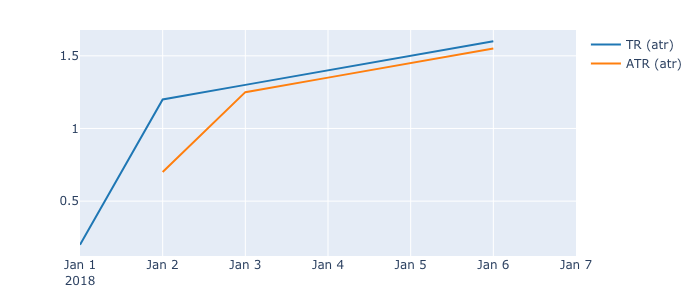

In [80]:
atr[(2, False, 'a')].plot().show_png()